<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

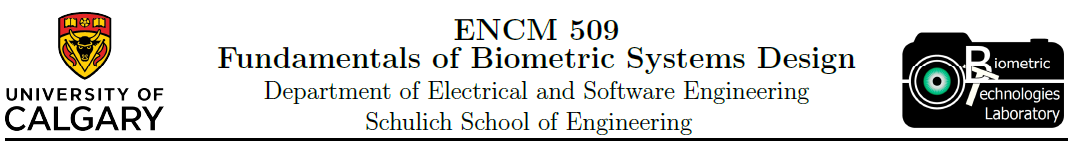

<center>
    <h1>Final Project</h1>
    <h2>Facial Detection</h2>
</center>

Aidan Johnson (30043501)

Cameron Faith (30025734)

April 11th, 2022

In [150]:
import sys
import cv2
import dlib
import skimage
import csv
import numpy as np
# import imutils

import matplotlib.pyplot as plt
from matplotlib import patches

## Introduction

The purpose of this project is to explore three differnet methods of facial detection and evaluate their performance. In this exercise, we will be using nine of our own personal images to complete facial detection. 


Throughout this project, we will go through examples covering Haar cascades, LBP cascade, and finally the performance of HOG+SVM face detection.

### **Common Functions**
Below are a list of the common functions to be used in the project.

In [151]:
"""
Takes in an image path and coverts the image to grayscale.

"""
def convertImageToGrayScale(imPath=None):
    if imPath is None:
        print("No image path was passed!")
        return
    
    image = cv2.imread(imPath)
    grayScaleImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return grayScaleImage

"""
Plots an image in grayscale.

"""
def viewImage(im=None):
    if im is None:
        print("No image was passed!")
        return

    #image = plt.imread(im)
    plt.imshow(im,cmap='gray', vmin=0, vmax=255)
    plt.show()
    return

"""
Performs the Haars cascade facial detection. Different parameters can be passed in to 
change the performance of the haars facial detection algorithm. Returns all the different
faces detected.
"""
def haarsFaceDetect(faceCascade, grayImage, minSize, scaleFactor=1.1, minNeighbors=5):
    faces = faceCascade.detectMultiScale(
                                            grayImage,
                                            scaleFactor=scaleFactor,
                                            minNeighbors=minNeighbors,
                                            minSize=minSize,
                                            flags=cv2.CASCADE_SCALE_IMAGE
                                        )
    return faces

"""
Performs the LBP-based Haars cascade for frontal facial detection using OpenCV. Different parameters can be passed in to change the performance of the haars facial detection algorithm. Returns all the different faces detected. 
"""
def lbpHaarsFaceDetectCV(grayImage, minSize, scaleFactor=1.1, minNeighbors=5):
    # Load LBP cascade classifier training
    lbpFaceCascade = cv2.CascadeClassifier('lbpcascade_frontalface_improved.xml')
    faces = lbpFaceCascade.detectMultiScale(
                                            grayImage,
                                            scaleFactor=scaleFactor,
                                            minNeighbors=minNeighbors,
                                            minSize=minSize,
                                            flags=cv2.CASCADE_SCALE_IMAGE
                                        )
    return faces

"""
Performs the LBP-based Haars cascade for frontal facial detection using Skimage. Different parameters can be passed in to change the performance of the haars facial detection algorithm. Returns all the different faces detected. 

Output Dicts have form {'r': int, 'c': int, 'width': int, 'height': int}, where 'r' represents row position of top left corner of detected window, 'c' - col position, 'width' - width of detected window, 'height' - height of detected window.
"""
def lbpHaarsFaceDetectSki(grayImage, min_size=(30,30), max_size=(1000,1000), scale_factor=1.1, step_ratio=1.1):
    # Load LBP cascade classifier training
    lbpFaceCascade = skimage.feature.Cascade('lbpcascade_frontalface_improved.xml')
    
    faces = lbpFaceCascade.detect_multi_scale(
                                            grayImage,
                                            scale_factor=scale_factor,
                                            step_ratio=step_ratio,
                                            min_size=min_size,
                                            max_size=max_size,
                                        )
    return faces 


"""
Calculates the interzection over union between the ground truth box of an image and the
predicted box for face detection.

"""
def calcIntersectiontionOverUnion(groundTruthBox, predictedBox):
    # print(groundTruthBox)
    # print(predictedBox)
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(groundTruthBox[0], predictedBox[0])
    yA = max(groundTruthBox[1], predictedBox[1])
    xB = min(groundTruthBox[2], predictedBox[2])
    yB = min(groundTruthBox[3], predictedBox[3])
    # print(f"xA = {xA}, yA = {yA}, xB = {xB}, yB = {yB}")

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA+1) * max(0, yB - yA+1)
    # print(f"The inter Area is {interArea}")

    # compute the area of both the prediction and ground-truth
    # rectangles
    groundTruthBoxArea = (groundTruthBox[2] - groundTruthBox[0] + 1) * (groundTruthBox[3] - groundTruthBox[1] + 1)
    # print(f"Ground truth area is {groundTruthBoxArea}")
    predictedBoxArea = (predictedBox[2] - predictedBox[0] + 1) * (predictedBox[3] - predictedBox[1] + 1)
    # print(f"Predicted area is {predictedBoxArea}")
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(groundTruthBoxArea + predictedBoxArea - interArea)
    # return the intersection over union value
    return iou

"""
Plots a rectangle on the given plot based on the coordinates given by x, y, width and height as well as with a certain specified color. 
These values are located in the respective indeces of each item in rectangles. I.e. rectangles = [[x_coord, y_coord, width, height, color], ...]

"""
def plotRectangle(grayImage, rectangles):

    plt.imshow(grayImage)
    img_desc = plt.gca()
    plt.set_cmap('gray')

    for rect in rectangles:
        img_desc.add_patch(
                    patches.Rectangle(
                        (rect[0], rect[1]),
                        rect[2],
                        rect[3],
                        fill=False,
                        color=rect[4],
                        linewidth=2
                    )
                )
    plt.show()
"""
Performs the LBP-based Haars cascade for frontal facial detection using Skimage. Different parameters can be passed in to change the performance of the haars facial detection algorithm. Returns all the different faces detected. 

Will load in the number of images specified by min and max image variables. Properties such as min_size, max_size, scale_factor and step ratio can all be changed.
"""
def testLBPdetect(groundTrueBoundingBox, minImage=1, maxImage=9,  min_size=(30,30), max_size=(1000,1000), scale_factor=1.1, step_ratio=1.4):
    iou_array = []
    for imageNum in range(minImage, maxImage):
        imagePath = f"Images/personal/{imageNum}.jpg"
        grayImage = convertImageToGrayScale(imagePath)
        faces = lbpHaarsFaceDetectSki(grayImage, min_size=min_size, max_size=max_size, scale_factor=scale_factor, step_ratio=step_ratio)

        rectangles = []
        for patch in faces:
            rectangles.append([patch['c'], patch['r'], patch['width'], patch['height'], 'r'])

        for box in groundTrueBoundingBox[imageNum]:
            rectangles.append([box[0], box[1], box[2]-box[0], box[3]-box[1], 'g'])
            iouScores = []
            
            for patch in faces:
                predictedBox = [patch['c'], patch['r'], patch['c']+ patch['width'], patch['r']+ patch['height']]
                iouScores.append(calcIntersectiontionOverUnion(np.array(box), predictedBox))

            if len(iouScores) == 0:
                print(f"No faces were detected!")
                iou_array.append(-1)
            else:
                print(f"The max IoU Score is: {max(iouScores)}")
                iou_array.append(max(iouScores))
            
        plotRectangle(grayImage, rectangles)
    return iou_array
            
def testHaarsCascadeDetect(groundTrueBoundingBox, minImage=1, maxImage=9, scaleFactor=1.1, minNeighbors=5):
    haarsCascadeIoUScores = []
    for imageNum in range(minImage,maxImage):
        imagePath = f"Images/personal/{imageNum}.jpg"
        grayImage = convertImageToGrayScale(imagePath)
        #viewImage(grayImage)

        boundingBoxes = []
        faces = haarsFaceDetect(faceCascade, grayImage, minSize=(30,30), scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        # Draw a rectangle around the faces
        for (x, y, w, h) in faces:
            boundingBoxes.append([x,y,w,h,'r'])
        
        # print(faces)

        for groundTruthBB in groundTrueBoundingBox[imageNum]:
            boundingBoxes.append([groundTruthBB[0], groundTruthBB[1], groundTruthBB[2]-groundTruthBB[0], groundTruthBB[3]-groundTruthBB[1], 'g'])
            iouScores = []
            # Draw a rectangle around the faces
            for (x, y, w, h) in faces:
                predictedBox = [x, y, x+w, y+h]
                iouScores.append(calcIntersectiontionOverUnion(np.array(groundTruthBB), predictedBox))
            
            if len(iouScores) == 0:
                print(f"No faces were detected!")
                haarsCascadeIoUScores.append(-1)
            else:
                print(f"The max IoU Score is: {max(iouScores)}")
                haarsCascadeIoUScores.append(max(iouScores))


        #Displaying the facial detection
        plotRectangle(grayImage, boundingBoxes)
    return haarsCascadeIoUScores
    
"""
Based off of a specified threshold value this function calculates the total number of 
true positives and false negatives which can be used to create a confusion matrix.
"""
def calcTP_FPandFN(thresholdValue, iouScores):
    numOfTP = 0
    numOfFN = 0
    numOfFP = 0

    for iouScore in iouScores:
        if iouScore >= thresholdValue:
            numOfTP += 1
        elif iouScore == -1:
            numOfFN += 1
        else:
            numOfFP += 1
    
    return numOfTP, numOfFP, numOfFN

def calcRecall_Precision(thresholdValue, TP, FN, FP):
    recall = TP /float(TP + FN)
    precision = TP / float(TP + FP)
    return recall, precision, thresholdValue

def calc_recall_precision_array(threshold_list, iouScores):
  recall_precision_array = [[],[],[]]
  for threshold in threshold_list:
      numOfTP, numOfFP, numOfFN = calcTP_FPandFN(threshold, iouScores)
      recall, precision, threshold = calcRecall_Precision(threshold, numOfTP, numOfFN, numOfFP)
      recall_precision_array[0].append(recall)
      recall_precision_array[1].append(precision)
      recall_precision_array[2].append(threshold)
  return recall_precision_array

def calc_best_index(iou_list):
    best_index=0
    best_sum=0
    for index in range(len(iou_list)):
        sum_array=0
        for iou in iou_list[index]:
            sum_array+=iou
        if sum_array > best_sum:
            best_sum = sum_array
            best_index=index

    return best_index
         

def plotPrecisionVsRecall(recallPrecisionArr):
    plt.plot(recallPrecisionArr[0], recallPrecisionArr[1])
    plt.title('Precision vs Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    return

def plotPrecisionRecallThreshold(recallPrecisionArr):
    plt.plot(recallPrecisionArr[2], recallPrecisionArr[0], label = "Recall")
    plt.plot(recallPrecisionArr[2], recallPrecisionArr[1], label = "Precision")
    plt.legend()
    plt.title('Precision and Recall For Different Threshold Values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.show()
    return


## Initialization
In the setup of our project, we will be initializing the face cascade and ground truth boxes for the 9 images. Since we are using our own personal images for this project, we had to manually place the coordinates for each image. These values are stored in a csv file that is loaded at the start of the program.

In [152]:
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

groundTrueBoundingBox = [[] for i in range(10)]

with open("updatedGroundTruthBBox.csv") as csvFile:
    groundTruthBoundingBoxes = csv.reader(csvFile, delimiter=',')

    rowCount = 0
    for groundTruthBoundingBox in groundTruthBoundingBoxes:
        if rowCount == 0:
            rowCount += 1
            continue

        imageNumber = int(groundTruthBoundingBox[0])
        coordinates = groundTruthBoundingBox[1:]
        intCoordinates = [int(coordinates[0]), int(coordinates[1]), int(coordinates[2]), int(coordinates[3])]

        groundTrueBoundingBox[imageNumber].append(intCoordinates)
        rowCount += 1

## Procedure

### Haars Cascade

##### With scale factor set to 1.1 (base), minNeighbors set to 5 (base)

The max IoU Score is: 0.7727272727272727


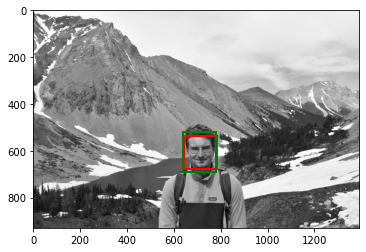

The max IoU Score is: 0.6316580127266844


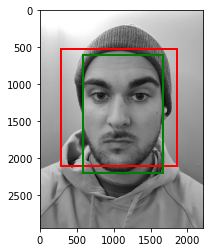

The max IoU Score is: 0.737968493422596


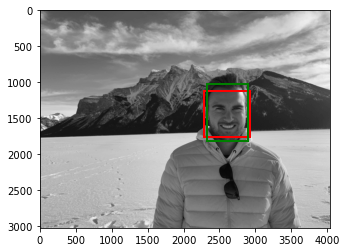

The max IoU Score is: 0.7807065553221165
The max IoU Score is: 0.7326549921670208


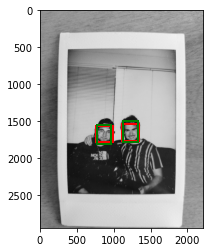

The max IoU Score is: 0.7643694175967617


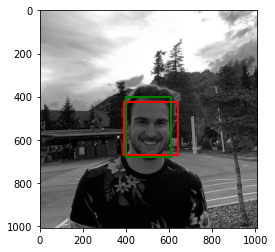

The max IoU Score is: 0.7007722007722008


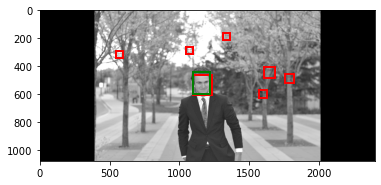

The max IoU Score is: 0.5957845433255269


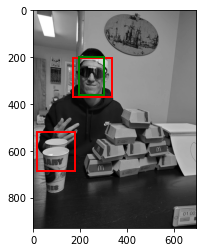

No faces were detected!


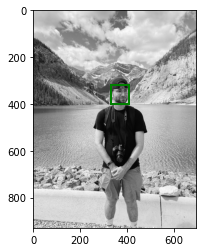

In [153]:
haarsCascadeIoUScores1 = testHaarsCascadeDetect(groundTrueBoundingBox, minImage=1, maxImage=9, scaleFactor=1.1, minNeighbors=5)

Computing number of TP, FP and FN

In [154]:
numOfTP, numOfFP, numOfFN = calcTP_FPandFN(0.5, haarsCascadeIoUScores1)
print(f"The number of true positives is {numOfTP}")
print(f"The number of false positives is {numOfFP}")
print(f"The number of false negatives is {numOfFN}")

The number of true positives is 8
The number of false positives is 0
The number of false negatives is 1


##### With Scale factor set to 2, minNeighbors set to 5 (base) 

No faces were detected!


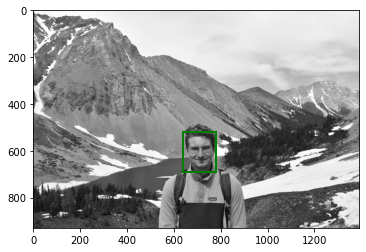

The max IoU Score is: 0.6466419460136641


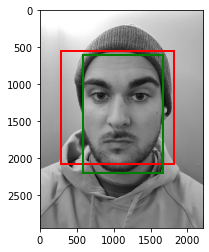

No faces were detected!


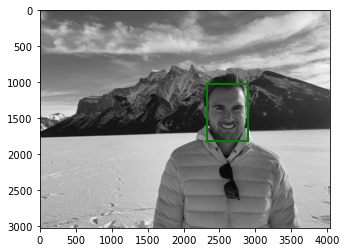

The max IoU Score is: 0.7037641964523114
The max IoU Score is: 0.6538447965557398


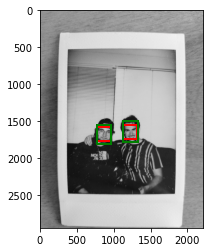

No faces were detected!


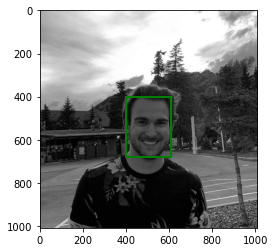

The max IoU Score is: 0.5034585111175893


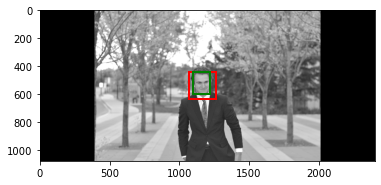

No faces were detected!


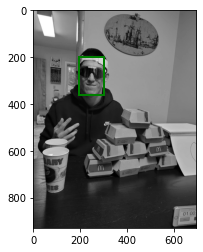

No faces were detected!


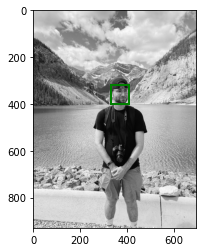

In [155]:
haarsCascadeIoUScores2 = testHaarsCascadeDetect(groundTrueBoundingBox, minImage=1, maxImage=9, scaleFactor=2, minNeighbors=5)

Computing Number of TP, FP and FN

In [46]:
numOfTP, numOfFP, numOfFN = calcTP_FPandFN(0.5, haarsCascadeIoUScores2)
print(f"The number of true positives is {numOfTP}")
print(f"The number of false positives is {numOfFP}")
print(f"The number of false negatives is {numOfFN}")

The number of true positives is 4
The number of false positives is 0
The number of false negatives is 5


##### With Scale factor set to 1.1 (base), minNeighbors set to 3

The max IoU Score is: 0.7727272727272727


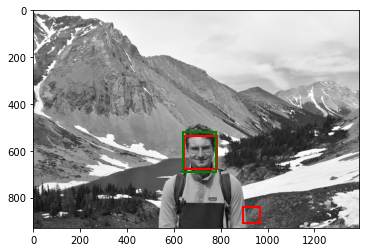

The max IoU Score is: 0.6316580127266844


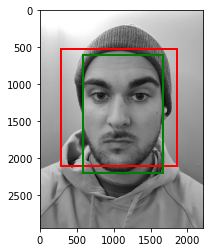

The max IoU Score is: 0.737968493422596


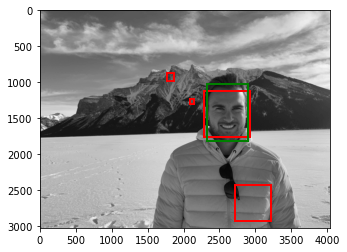

The max IoU Score is: 0.7807065553221165
The max IoU Score is: 0.7326549921670208


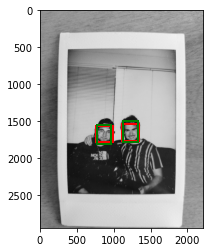

The max IoU Score is: 0.7643694175967617


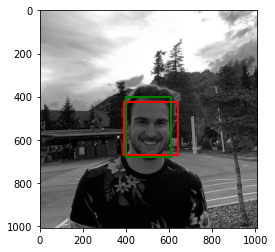

The max IoU Score is: 0.7007722007722008


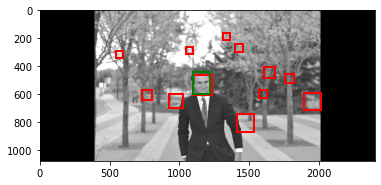

The max IoU Score is: 0.5957845433255269


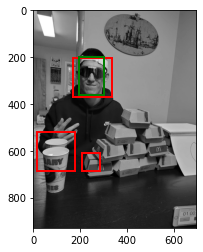

The max IoU Score is: 0.0


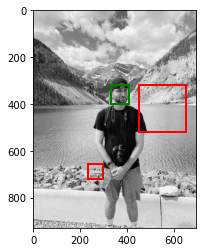

In [156]:
haarsCascadeIoUScores3 = testHaarsCascadeDetect(groundTrueBoundingBox, minImage=1, maxImage=9, scaleFactor=1.1, minNeighbors=3)

Computing Number of TP, FP and FN

In [157]:
numOfTP, numOfFP, numOfFN = calcTP_FPandFN(0.5, haarsCascadeIoUScores3)
print(f"The number of true positives is {numOfTP}")
print(f"The number of false positives is {numOfFP}")
print(f"The number of false negatives is {numOfFN}")

The number of true positives is 8
The number of false positives is 1
The number of false negatives is 0


The scale factor being 1.1 and minNeighbors beinging 5 seemed to be the best parameters.

In [158]:
Haars_recall_precision_thresholds = [] # [[recall, precision, threshold], ...]

thresholdlist = np.linspace(0,1,100)

Haars_recall_precision_thresholds = (calc_recall_precision_array(thresholdlist, haarsCascadeIoUScores1))

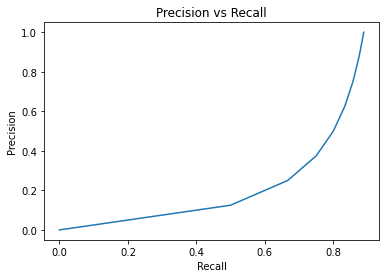

In [159]:
plotPrecisionVsRecall(Haars_recall_precision_thresholds)

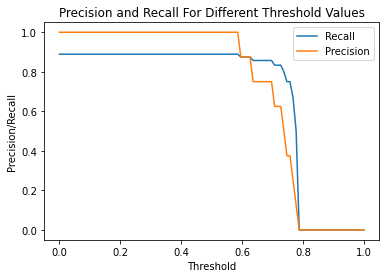

In [167]:
plotPrecisionRecallThreshold(Haars_recall_precision_thresholds)

### LBP
Investigating various parameters for the LBP-based Haar cascades. We will investigate 3 different iterations of scale_ratio and step_ratio and then 2 iterations of min_size and max_size.

**Varying scale_ratio all other parameters constant.**

The max IoU Score is: 0.335946248600224


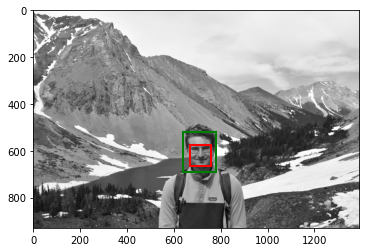

The max IoU Score is: 0.4277042744984007


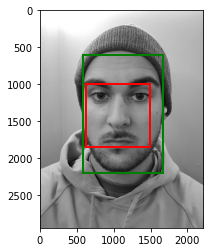

The max IoU Score is: 0.3507140738414294


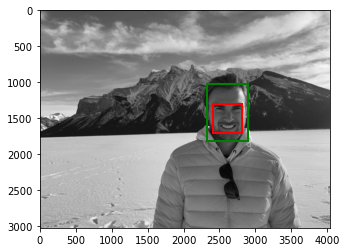

The max IoU Score is: 0.4941003793294066
The max IoU Score is: 0.4198934154848533


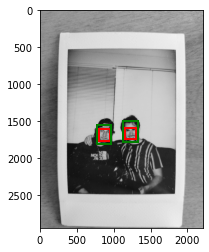

The max IoU Score is: 0.40520483715909666


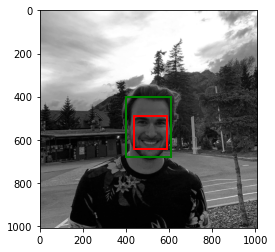

The max IoU Score is: 0.33678969252091784


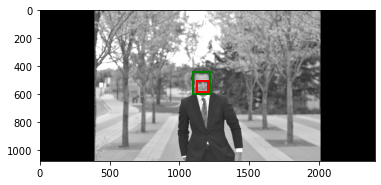

No faces were detected!


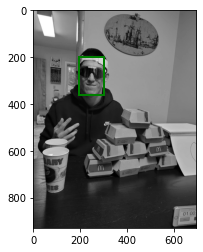

The max IoU Score is: 0.33668648071940255


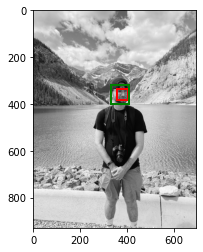

The max IoU Score is: 0.29965575878229855


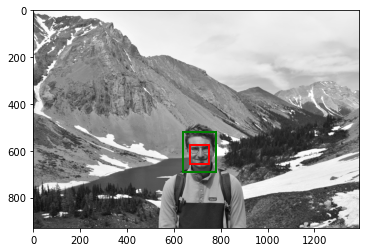

The max IoU Score is: 0.31338071237024423


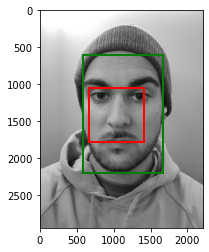

The max IoU Score is: 0.2551036432160804


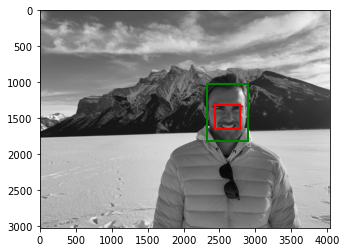

The max IoU Score is: 0.44040334724843216
The max IoU Score is: 0.44198934154848535


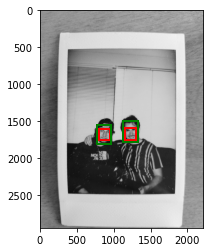

The max IoU Score is: 0.3896712823194077


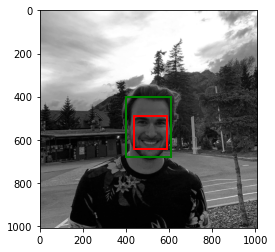

The max IoU Score is: 0.33678969252091784


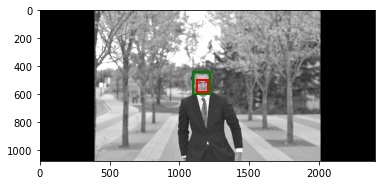

No faces were detected!


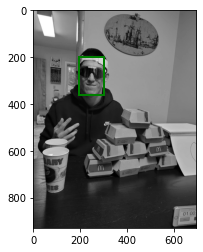

The max IoU Score is: 0.32251181222374636


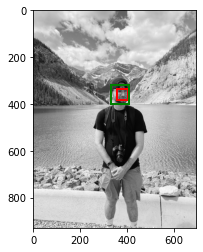

The max IoU Score is: 0.34345319563684623


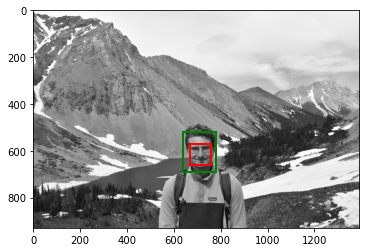

The max IoU Score is: 0.2999216503505541


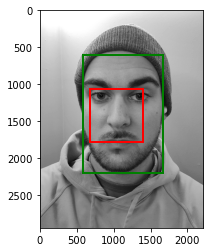

The max IoU Score is: 0.3865704390005584


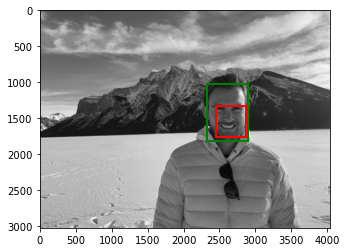

The max IoU Score is: 0.5379996568879739
The max IoU Score is: 0.5800357642393017


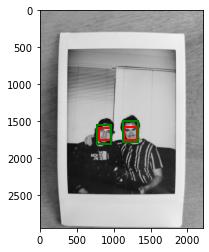

The max IoU Score is: 0.5525459175928893


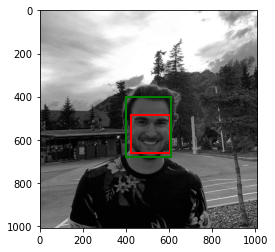

The max IoU Score is: 0.362199065756378


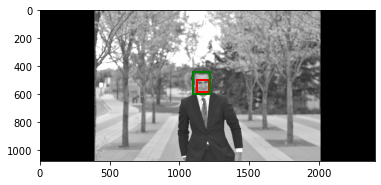

No faces were detected!


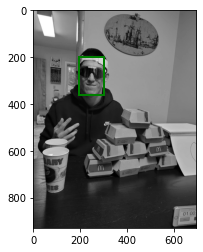

The max IoU Score is: 0.32251181222374636


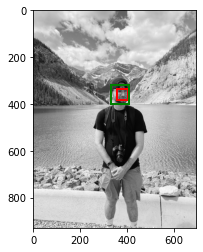

[[0.335946248600224,
  0.4277042744984007,
  0.3507140738414294,
  0.4941003793294066,
  0.4198934154848533,
  0.40520483715909666,
  0.33678969252091784,
  -1,
  0.33668648071940255],
 [0.29965575878229855,
  0.31338071237024423,
  0.2551036432160804,
  0.44040334724843216,
  0.44198934154848535,
  0.3896712823194077,
  0.33678969252091784,
  -1,
  0.32251181222374636],
 [0.34345319563684623,
  0.2999216503505541,
  0.3865704390005584,
  0.5379996568879739,
  0.5800357642393017,
  0.5525459175928893,
  0.362199065756378,
  -1,
  0.32251181222374636]]

In [124]:
lbp_scale_ratio_iou = []
lbp_scale_ratio_iou.append(testLBPdetect(groundTrueBoundingBox, scale_factor=1.1))
lbp_scale_ratio_iou.append(testLBPdetect(groundTrueBoundingBox, scale_factor=1.5))
lbp_scale_ratio_iou.append(testLBPdetect(groundTrueBoundingBox, scale_factor=2))
lbp_scale_ratio_iou

**Varying step_ratio all other parameters constant.**

The max IoU Score is: 0.3067479573638588


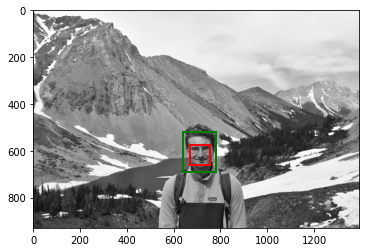

The max IoU Score is: 0.4227511688983047


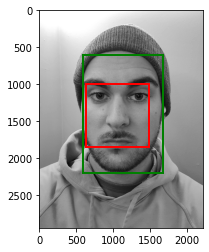

The max IoU Score is: 0.3351479620323841


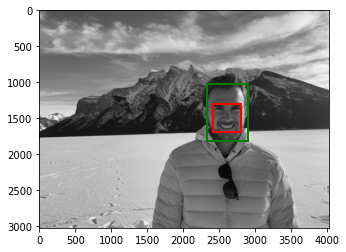

The max IoU Score is: 0.48190084062446387
The max IoU Score is: 0.4704059772312813


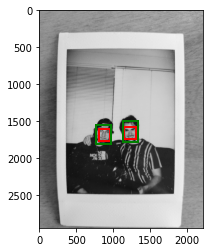

The max IoU Score is: 0.3896712823194077


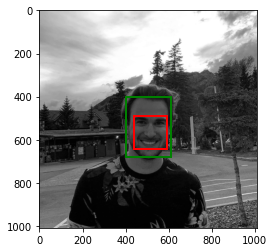

The max IoU Score is: 0.3536266105436066


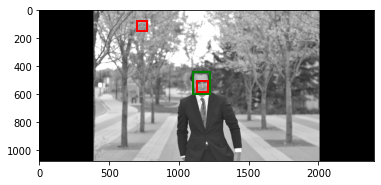

No faces were detected!


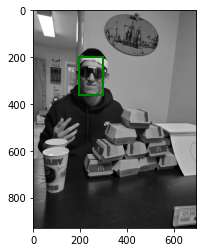

The max IoU Score is: 0.42813595488492606


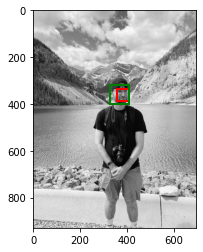

The max IoU Score is: 0.29965575878229855


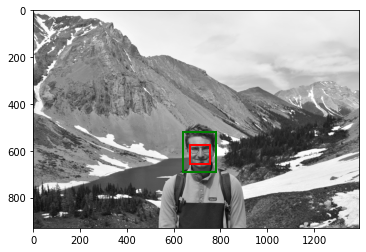

The max IoU Score is: 0.41098141301688845


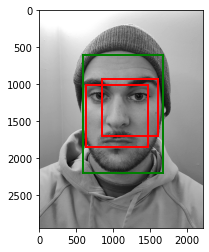

The max IoU Score is: 0.31826668062534896


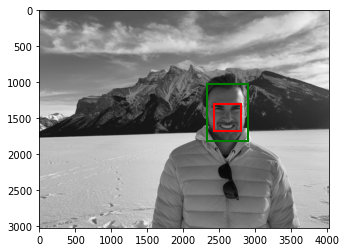

The max IoU Score is: 0.5064524122681611
The max IoU Score is: 0.5583368689011455


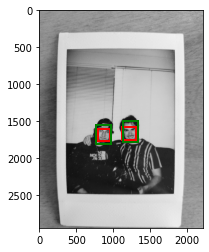

The max IoU Score is: 0.4104501526369938


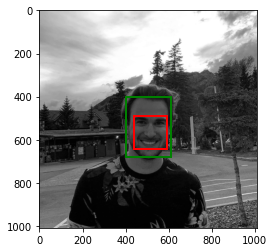

The max IoU Score is: 0.32852522971100045


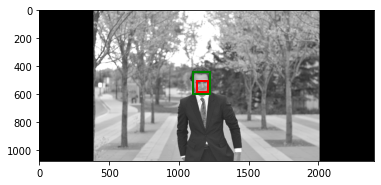

No faces were detected!


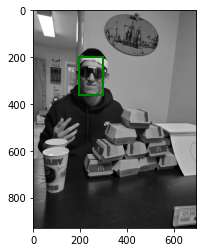

The max IoU Score is: 0.39643347050754457


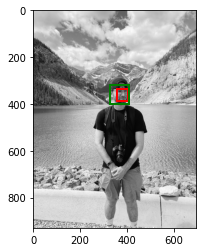

The max IoU Score is: 0.3664717348927875


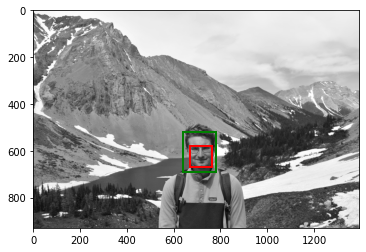

The max IoU Score is: 0.4306899846300835


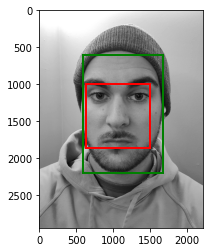

The max IoU Score is: 0.32328526312116135


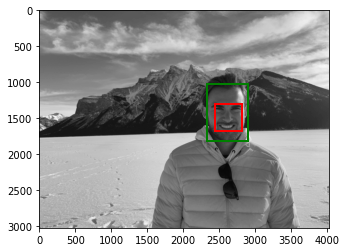

The max IoU Score is: 0.4638874592554469
The max IoU Score is: 0.594128952157423


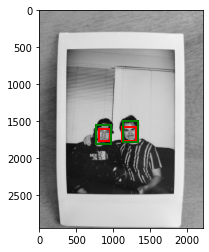

The max IoU Score is: 0.38456089457084547


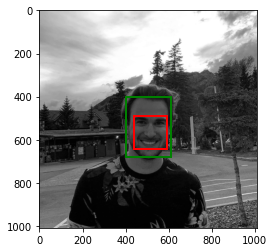

The max IoU Score is: 0.3536266105436066


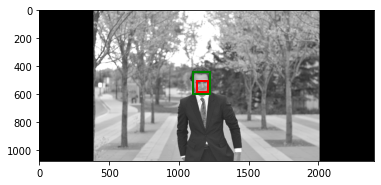

No faces were detected!


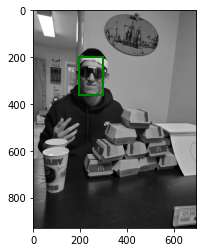

The max IoU Score is: 0.39643347050754457


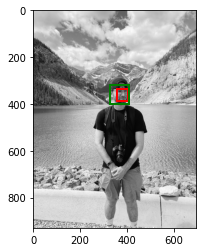

[[0.3067479573638588,
  0.4227511688983047,
  0.3351479620323841,
  0.48190084062446387,
  0.4704059772312813,
  0.3896712823194077,
  0.3536266105436066,
  -1,
  0.42813595488492606],
 [0.29965575878229855,
  0.41098141301688845,
  0.31826668062534896,
  0.5064524122681611,
  0.5583368689011455,
  0.4104501526369938,
  0.32852522971100045,
  -1,
  0.39643347050754457],
 [0.3664717348927875,
  0.4306899846300835,
  0.32328526312116135,
  0.4638874592554469,
  0.594128952157423,
  0.38456089457084547,
  0.3536266105436066,
  -1,
  0.39643347050754457]]

In [50]:
lbp_step_ratio_iou = []
lbp_step_ratio_iou.append(testLBPdetect(groundTrueBoundingBox, step_ratio=1.1))
lbp_step_ratio_iou.append(testLBPdetect(groundTrueBoundingBox, step_ratio=1.5))
lbp_step_ratio_iou.append(testLBPdetect(groundTrueBoundingBox, step_ratio=2))
lbp_step_ratio_iou

**Varying min_size all other parameters constant.**


The max IoU Score is: 0.32118120360001656


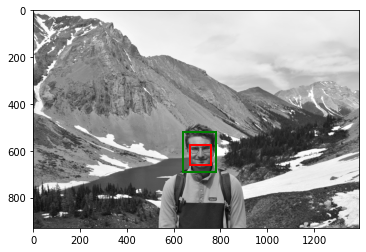

The max IoU Score is: 0.4178269107390945


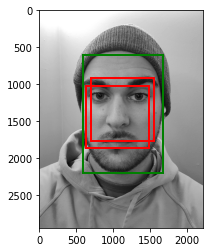

The max IoU Score is: 0.4032750558347292


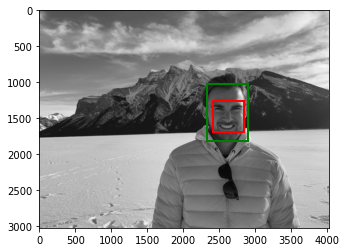

The max IoU Score is: 0.4879815481977088
The max IoU Score is: 0.4997078663621395


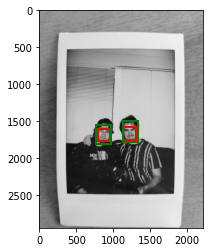

The max IoU Score is: 0.36943212291916144


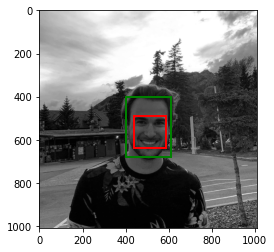

The max IoU Score is: 0.3708741851034341


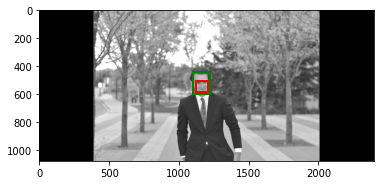

No faces were detected!


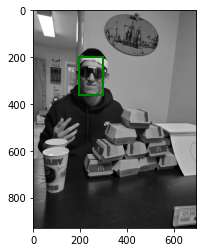

The max IoU Score is: 0.42813595488492606


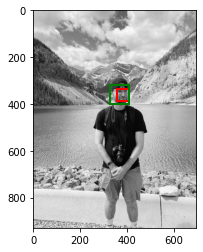

No faces were detected!


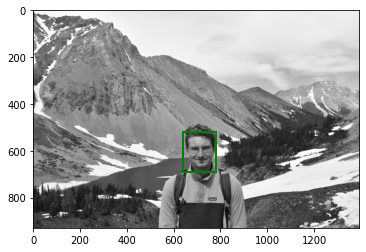

The max IoU Score is: 0.3955468782453371


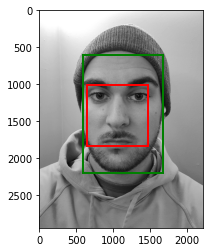

The max IoU Score is: 0.3559812953657175


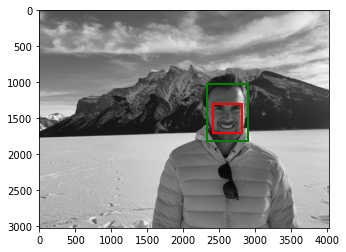

No faces were detected!
No faces were detected!


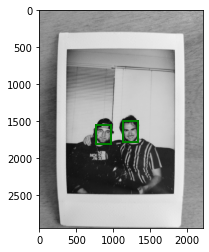

No faces were detected!


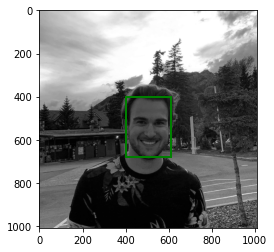

No faces were detected!


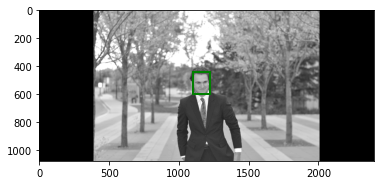

No faces were detected!


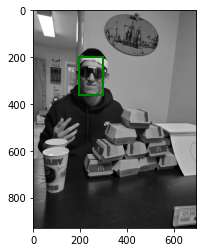

No faces were detected!


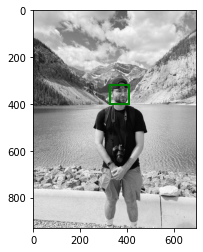

[[0.32118120360001656,
  0.4178269107390945,
  0.4032750558347292,
  0.4879815481977088,
  0.4997078663621395,
  0.36943212291916144,
  0.3708741851034341,
  -1,
  0.42813595488492606],
 [-1, 0.3955468782453371, 0.3559812953657175, -1, -1, -1, -1, -1, -1]]

In [51]:
lbp_min_size_iou = []
lbp_min_size_iou.append(testLBPdetect(groundTrueBoundingBox, min_size=(50,50)))
lbp_min_size_iou.append(testLBPdetect(groundTrueBoundingBox, min_size=(200,200)))
lbp_min_size_iou

**Varying max_size all other parameters constant.**


The max IoU Score is: 0.3743104806934594


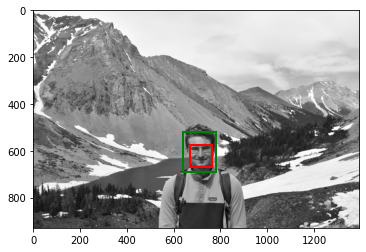

No faces were detected!


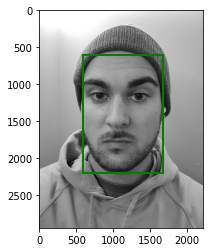

The max IoU Score is: 0.3454861111111111


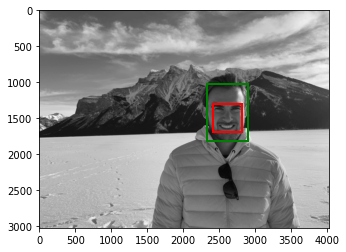

The max IoU Score is: 0.48190084062446387
The max IoU Score is: 0.4253642817938776


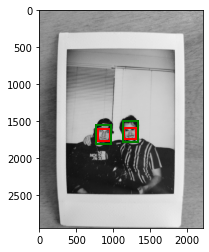

The max IoU Score is: 0.4157292000472247


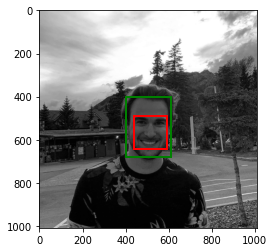

The max IoU Score is: 0.34515681946511984


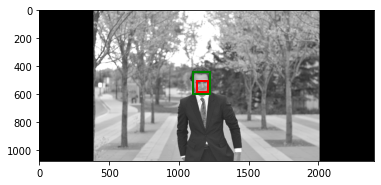

No faces were detected!


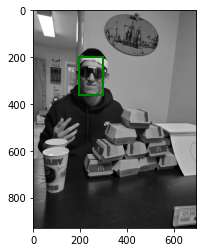

The max IoU Score is: 0.3511659807956104


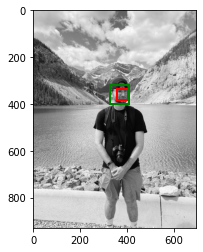

The max IoU Score is: 0.3743104806934594


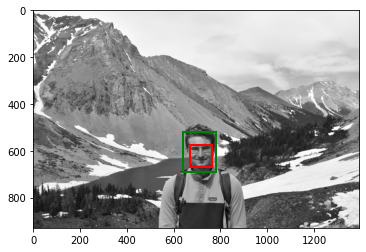

The max IoU Score is: 0.5372691627780316


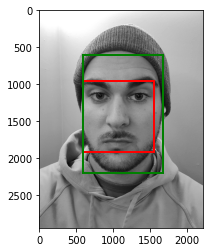

The max IoU Score is: 0.3454861111111111


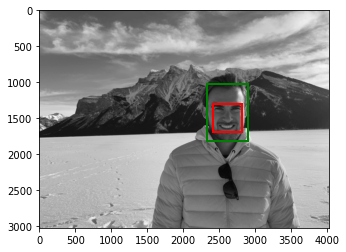

The max IoU Score is: 0.48190084062446387
The max IoU Score is: 0.4253642817938776


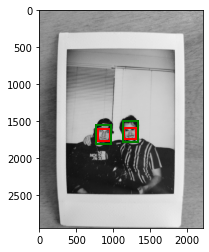

The max IoU Score is: 0.4157292000472247


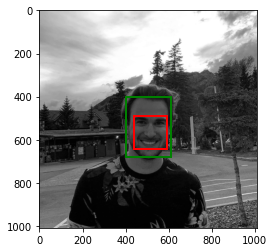

The max IoU Score is: 0.34515681946511984


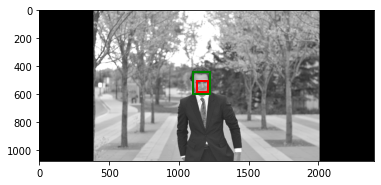

No faces were detected!


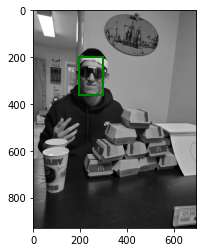

The max IoU Score is: 0.3511659807956104


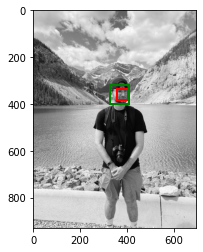

[[0.3743104806934594,
  -1,
  0.3454861111111111,
  0.48190084062446387,
  0.4253642817938776,
  0.4157292000472247,
  0.34515681946511984,
  -1,
  0.3511659807956104],
 [0.3743104806934594,
  0.5372691627780316,
  0.3454861111111111,
  0.48190084062446387,
  0.4253642817938776,
  0.4157292000472247,
  0.34515681946511984,
  -1,
  0.3511659807956104]]

In [52]:
lbp_max_size_iou = []
lbp_max_size_iou.append(testLBPdetect(groundTrueBoundingBox, max_size=(500,500)))
lbp_max_size_iou.append(testLBPdetect(groundTrueBoundingBox, max_size=(1500,1500)))
lbp_max_size_iou

**Determining the best overall parameters**

In [66]:
best_param_index = calc_best_index(lbp_scale_ratio_iou)
print(f"Best parameter iteration for scale ratio: {best_param_index}")

best_param_index = calc_best_index(lbp_scale_ratio_iou)
print(f"Best parameter iteration for step ratio: {best_param_index}")

best_param_index = calc_best_index(lbp_min_size_iou)
print(f"Best parameter iteration for min size: {best_param_index}")

best_param_index = calc_best_index(lbp_max_size_iou)
print(f"Best parameter iteration for max size: {best_param_index}")

Best parameter iteration for scale ratio: 2
Best parameter iteration for step ratio: 2
Best parameter iteration for min size: 0
Best parameter iteration for max size: 1


**Calculating IOU using the best parameters**
<br>We noticed that the calculation above resulted in worse performance than the default as we only changed one parameter at a time. Thus we opted to use the parameters that resulted in the highest overall score together.

The max IoU Score is: 0.29965575878229855


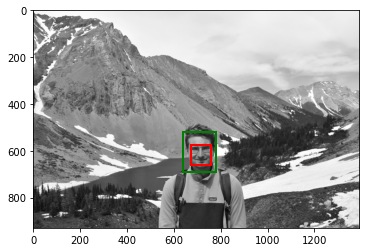

The max IoU Score is: 0.5695290343577107


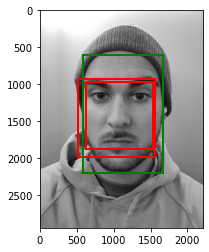

The max IoU Score is: 0.33686008165829145


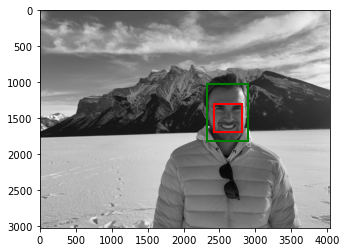

The max IoU Score is: 0.5002573340195574
The max IoU Score is: 0.3930702360085693


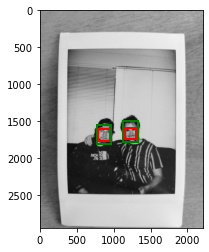

The max IoU Score is: 0.3999932536135333


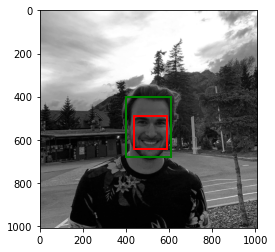

The max IoU Score is: 0.34515681946511984


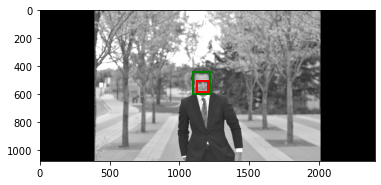

No faces were detected!


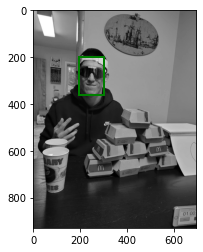

The max IoU Score is: 0.42813595488492606


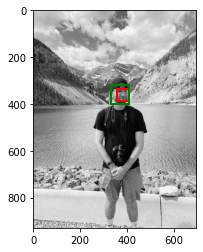

In [127]:
lbp_iou = testLBPdetect(groundTrueBoundingBox, scale_factor=1.1, min_size=(50,50), step_ratio=1.1, max_size=(1500,1500))

Computing Number of TP, FP and FN

In [128]:
lbp_recall_precision_thresholds = [] # [[recall, precision, threshold], ...]
# Needs to be different due to the LBP's bounding box being tighter
thresholdlist = np.linspace(0,1,10000)

print(lbp_iou)
lbp_recall_precision_thresholds = (calc_recall_precision_array(thresholdlist, lbp_iou))

[0.29965575878229855, 0.5695290343577107, 0.33686008165829145, 0.5002573340195574, 0.3930702360085693, 0.3999932536135333, 0.34515681946511984, -1, 0.42813595488492606]


**Charting Precision vs. Recall**

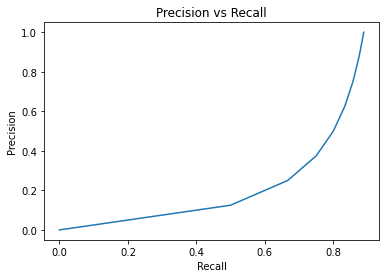

In [129]:
plotPrecisionVsRecall(lbp_recall_precision_thresholds)

**Charting Precision-Recall vs. Threshold**

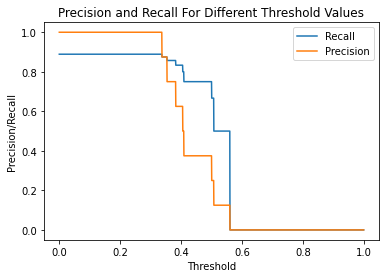

In [79]:
plotPrecisionRecallThreshold(lbp_recall_precision_thresholds)

### Hog + SVM

Number of faces detected: 1
The max IoU Score is: 0.6650156307092688


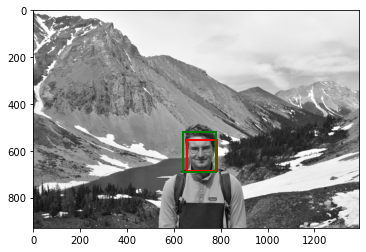

Number of faces detected: 1
The max IoU Score is: 0.654474029894674


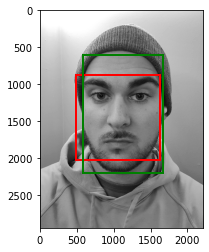

Number of faces detected: 1
The max IoU Score is: 0.6730265912897823


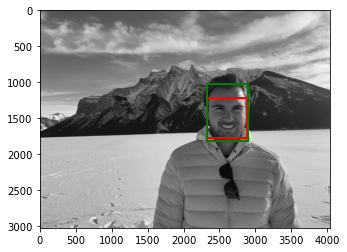

Number of faces detected: 2
The max IoU Score is: 0.781490288650131
The max IoU Score is: 0.6137855579868708


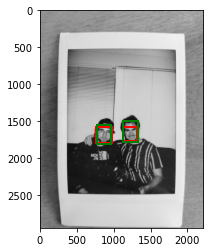

Number of faces detected: 1
The max IoU Score is: 0.5717603421773708


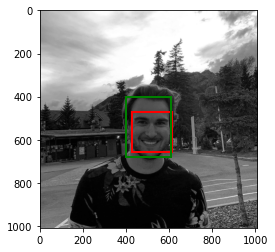

Number of faces detected: 1
The max IoU Score is: 0.6459756594127494


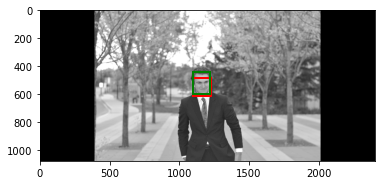

Number of faces detected: 0
No faces were detected!


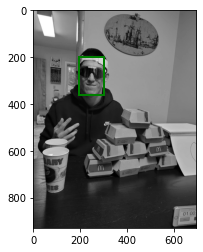

Number of faces detected: 1
The max IoU Score is: 0.5896739130434783


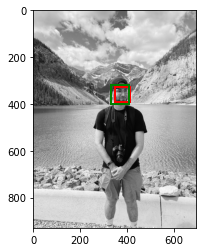

In [160]:
detector = dlib.get_frontal_face_detector()

hogIoUScores = []
for imageNum in range(1,9):
    imagePath = f"Images/personal/{imageNum}.jpg"
    grayImage = convertImageToGrayScale(imagePath)

    detectedFaces = detector(grayImage, 1)
    print("Number of faces detected: {}".format(len(detectedFaces)))

    boundingBoxes = []
    # Draw a rectangle for the detected faces
    # print(detectedFaces)
    for i, d in enumerate(detectedFaces):
        #print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(i, d.left(), d.top(), d.right(), d.bottom()))
        predictedBox = [d.left(), d.top(), d.right()-d.left(), d.bottom()-d.top(), 'r']
        boundingBoxes.append(predictedBox)

    for groundTruthBB in groundTrueBoundingBox[imageNum]:
        boundingBoxes.append([groundTruthBB[0], groundTruthBB[1], groundTruthBB[2] - groundTruthBB[0], groundTruthBB[3]-groundTruthBB[1], 'g'])
        iouScores = []
        for d in detectedFaces:
            predictedBox = [d.left(), d.top(), d.right(), d.bottom()]
            iouScores.append(calcIntersectiontionOverUnion(np.array(groundTruthBB), predictedBox))
        
        if len(iouScores) == 0:
            print(f"No faces were detected!")
            hogIoUScores.append(-1)
        else:
            print(f"The max IoU Score is: {max(iouScores)}")
            hogIoUScores.append(max(iouScores))


        # Finally, if you really want to you can ask the detector to tell you the score
        # for each detection.  The score is bigger for more confident detections.
        # The third argument to run is an optional adjustment to the detection threshold,
        # where a negative value will return more detections and a positive value fewer.
        # Also, the idx tells you which of the face sub-detectors matched.  This can be
        # used to broadly identify faces in different orientations.

        # dets, scores, idx = detector.run(grayImage, 1, -1)
        # for i, d in enumerate(dets):
        #     print("Detection {}, score: {}, face_type:{}".format(d, scores[i], idx[i]))

    #Displaying the facial detection
    plotRectangle(grayImage, boundingBoxes)

Computing Number of TP, FP and FN

In [163]:
numOfTP, numOfFP, numOfFN = calcTP_FPandFN(0.5, hogIoUScores)
print(f"The number of true positives is {numOfTP}")
print(f"The number of false positives is {numOfFP}")
print(f"The number of false negatives is {numOfFN}")

The number of true positives is 8
The number of false positives is 0
The number of false negatives is 1


In [164]:
HOG_recall_precision_thresholds = [] # [[recall, precision, threshold], ...]
# Needs to be different due to the LBP's bounding box being tighter
thresholdlist = np.linspace(0,1,100)

print(hogIoUScores)
HOG_recall_precision_thresholds = (calc_recall_precision_array(thresholdlist, hogIoUScores))

[0.6650156307092688, 0.654474029894674, 0.6730265912897823, 0.781490288650131, 0.6137855579868708, 0.5717603421773708, 0.6459756594127494, -1, 0.5896739130434783]


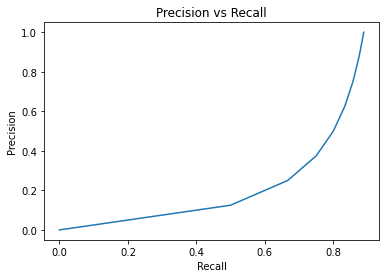

In [165]:
plotPrecisionVsRecall(HOG_recall_precision_thresholds)

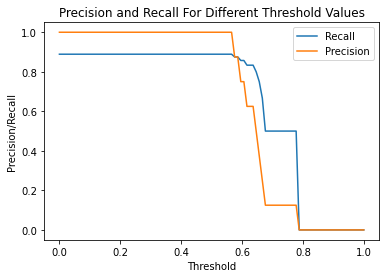

In [166]:
plotPrecisionRecallThreshold(HOG_recall_precision_thresholds)

# Conclusion
In conclusion, this lab illustrates concepts of the Bayesian network and in this lab we were able to explore its various properties including Bayes rule, joint probabilities, and finally the importance of a complete CPT. Throughout the lab, we challenged the theory learned in class by completing the exercise probability calculations manually first and then comparing them with the probabilities calculated by the PyAgrum library. 

As seen from examples 1 and 2, PyAgrum's calculation's aligned with the expected values calculated by hand and shows the library's usefulness in machine reasoning to accurately calculate different probabilities. In example, 3 and 4, we evaluated the importance of a complete CPT and why it is necessary to define all entries in the network.